# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [4]:
# Reading the data
tr_tr = pd.read_csv('./train_transaction.csv')
te_tr = pd.read_csv('./test_transaction.csv')
tr_id = pd.read_csv('./train_identity.csv')
te_id = pd.read_csv('./test_identity.csv')


COLS_TO_SHOW = int(tr_tr.shape[1] * 0.5)

# EDA Functions and Navigation

In [5]:
def h(content): # Function for displaying content in HTML/Markdown format
    display(HTML(content)) # display content in HTML/Markdown format


def timehist1(col): # Function for displaying line plot for a (transaction datetime/given column) - Time Histogram
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # Clip transaction amount for better view
    # Line plot for a (transaction datetime/given column) in train_transaction where isFraud is False 
    tr_tr[tr_tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    # Line plot for a (transaction datetime/given column) in train_transaction where isFraud is True
    tr_tr[tr_tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    # Line plot for a (transaction datetime/given column) in test_transaction
    te_tr.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show() # Show plot
    

def _desc(data, col, label): # Column description in a given dataset
    d0 = data.describe().reset_index() # Basic description (mean, std, min, max etc...) for a column
    d0.columns = [col, label]
    # Append column's unique values, number of NaNs and NaNs share and return it
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \


def desc1(col): # Function for column description
    d0 = _desc(tr_tr[col], col, 'Train') # Description for column in Train dataset
    d1 = _desc(tr_tr.loc[tr_tr['isFraud'] == 1, col], col, 'Train fraud') # Description for column in Train dataset where Fraud is True
    d2 = _desc(tr_tr.loc[tr_tr['isFraud'] == 0, col], col, 'Train Not fraud') # Description for column in Train dataset where Fraud is False
    d3 = _desc(te_tr[col], col, 'Test') # Description for column in Test dataset
    n_public = int(te_tr.shape[0] * 0.2) # 20% of test data
    d4 = _desc(te_tr.loc[:n_public, col], col, 'Test public') # Description for column in Test public (20%)
    d5 = _desc(te_tr.loc[n_public:, col], col, 'Test private') # Description for column in Test private (80%)
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5) # Merge all descriptive Datasets together
    display(dd) # Display the resulting descriptive Dataset

    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        # Size, mean and sum results for isFraud column grouped by a given column in Train dataset
        d0 = tr_tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        # Count results for TransactionID column grouped by a given column in Test dataset
        d1 = te_tr[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N) # Merge d0 and d1 results together
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        # Biggest values for d0 and d1 combined
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset


def hist1(col): # Function for histogram for a given column in Train and Test datasets
    plt.figure(figsize=(15, 3)) # Size of a plot
    plt.subplot(121) # Number of rows, number of columns and index for a subplot
    plt.hist(tr_tr[col], bins=70); # Histogram for a given column
    plt.title('Train histogram: ' + col); # Title for a histogram
    plt.subplot(122) # Number of rows, number of columns and index for a subplot
    plt.hist(te_tr[col], bins=70); # Histogram for a given column
    plt.title('Test histogram: ' + col); # Title for a histogram
    plt.show() # Show histograms


def corr1(col): # Function for the most correlated values for the given column - Correlation
    N = None #10000
    num_vars = [f for f in tr_tr.columns if tr_tr[f].dtype != 'object'] # List of all numeric columns
    trx = tr_tr.head(N) if N is not None else tr_tr.copy() # Temporary dataframe for the correlation results
    # The most correlated columns with the given column (Only numeric columns)
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)]) # Final correlation results to dataframe
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))


def numeric(col): # EDA for numeric columns
    timehist1(col) # Time histogram
    hist1(col) # Histogram of
    desc1(col) # Description
    corr1(col) # Correlation


def categorical(col): # EDA for categorical columns
    desc1(col) # Description


def proc(col): # Function for running eda
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr_tr[col].dtype == 'object' else numeric(col) # Make EDA for a column

# Navigation
included_cols = list(tr_tr.columns.values[COLS_TO_SHOW:])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
# Shapes of datasets
h('Train transactions shape: <b>' + str(tr_tr.shape) + '</b>, identity <b>' + str(tr_id.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te_tr.shape) + '</b>, identity <b>' + str(te_id.shape) + '</b>')
# train_transaction preview
h('Train transactions preview:')
display(tr_tr.head(10))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA for other Columns

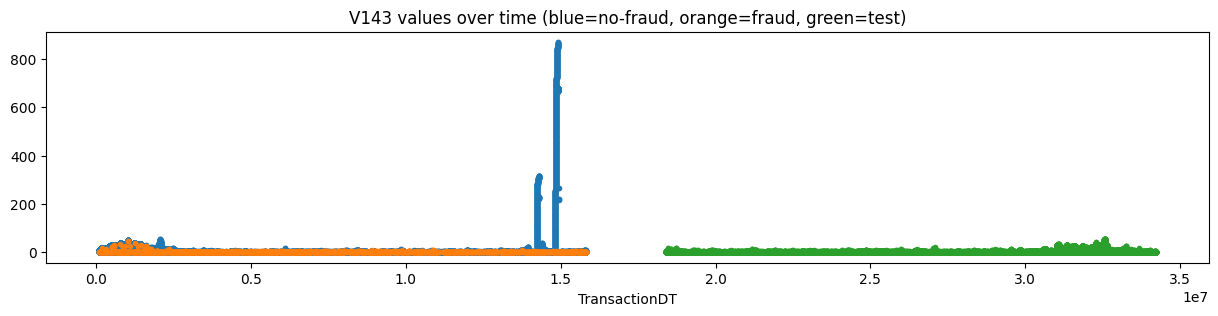

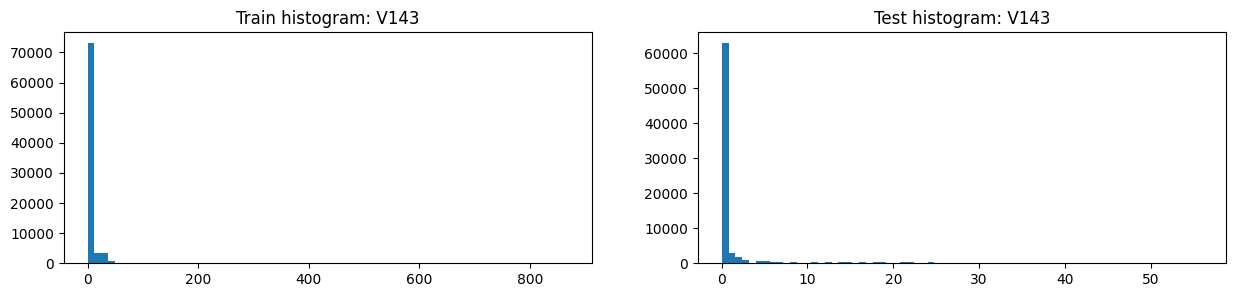

,V143,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,81951.000000,3651.000000,78300.000000,76055.000000,8913.000000,67142.000000
1,mean,8.397006,0.778417,8.752248,1.779607,0.372377,1.966414
2,std,55.267545,2.640451,56.513468,5.758042,1.294889,6.085725
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
7,max,869.000000,47.000000,869.000000,56.000000,17.000000,56.000000
8,unique values,871.000000,32.000000,871.000000,58.000000,19.000000,58.000000
9,NaNs,508589.000000,17012.000000,491577.000000,430636.000000,92426.000000,338211.000000


,V143,Count in train (desc),Mean target,Sum target,Count in test
0,-999.0,508589,0.033449,17012,430636.0
1,0.0,63872,0.038734,2474,62799.0
2,1.0,3767,0.183435,691,2835.0
3,2.0,1884,0.135881,256,1678.0
4,3.0,1032,0.102713,106,938.0
5,4.0,709,0.066291,47,680.0
6,28.0,584,0.001712,1,138.0
7,13.0,516,0.003876,2,99.0
8,30.0,417,0.000000,0,134.0
9,24.0,409,0.009780,4,325.0


,V143,Count in train,Mean target,Sum target (desc),Count in test
0,-999.0,508589,0.033449,17012,430636
1,0.0,63872,0.038734,2474,62799
2,1.0,3767,0.183435,691,2835
3,2.0,1884,0.135881,256,1678
4,3.0,1032,0.102713,106,938
5,4.0,709,0.066291,47,680
6,5.0,380,0.034211,13,537
7,6.0,264,0.034091,9,314
8,20.0,327,0.021407,7,187
9,7.0,213,0.032864,7,364


,Column,Correlation with V143
0,V143,1.000000
1,V164,0.996551
2,V101,0.989884
3,V293,0.989616
4,V95,0.989536
5,V322,0.989483
327,V20,-0.342771
328,V19,-0.345714
329,V62,-0.382845
330,V61,-0.386694


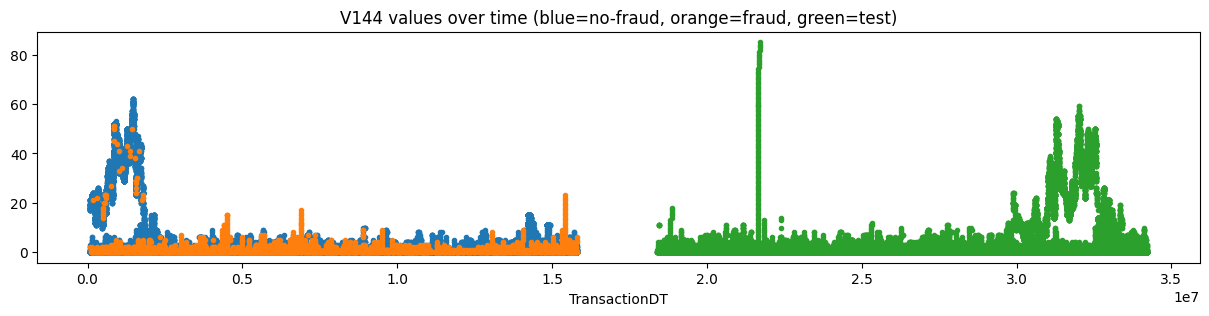

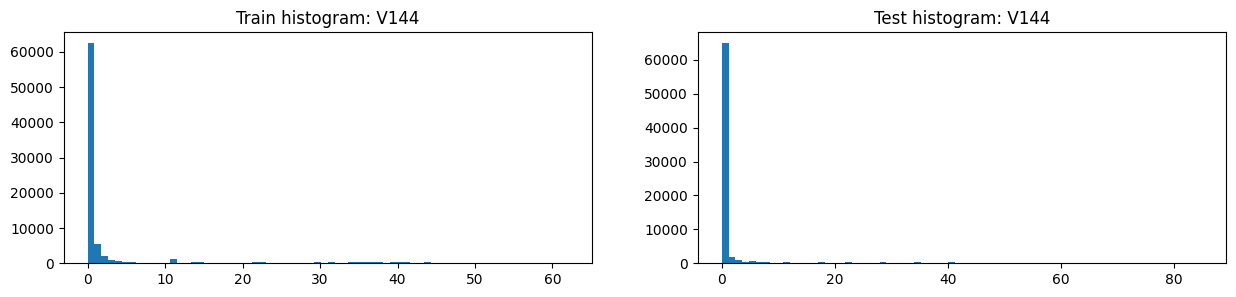

,V144,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,81951.000000,3651.000000,78300.000000,76055.000000,8913.000000,67142.000000
1,mean,3.708484,1.184881,3.826156,2.809572,0.808145,3.075258
2,std,10.485633,3.701618,10.682965,8.928725,4.980549,9.295715
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
7,max,62.000000,51.000000,62.000000,85.000000,85.000000,59.000000
8,unique values,64.000000,41.000000,64.000000,87.000000,87.000000,61.000000
9,NaNs,508589.000000,17012.000000,491577.000000,430636.000000,92426.000000,338211.000000


,V144,Count in train (desc),Mean target,Sum target,Count in test
0,-999.0,508589,0.033449,17012,430636
1,0.0,62439,0.036804,2298,59661
2,1.0,5418,0.116833,633,5189
3,2.0,2073,0.149059,309,1937
4,11.0,1089,0.006428,7,245
5,3.0,1054,0.148008,156,881
6,4.0,600,0.115000,69,476
7,15.0,435,0.013793,6,176
8,5.0,365,0.139726,51,376
9,40.0,364,0.000000,0,102


,V144,Count in train,Mean target,Sum target (desc),Count in test
0,-999.0,508589,0.033449,17012,430636
1,0.0,62439,0.036804,2298,59661
2,1.0,5418,0.116833,633,5189
3,2.0,2073,0.149059,309,1937
4,3.0,1054,0.148008,156,881
5,4.0,600,0.115000,69,476
6,5.0,365,0.139726,51,376
7,6.0,246,0.105691,26,303
8,7.0,107,0.158879,17,331
9,9.0,70,0.128571,9,148


,Column,Correlation with V144
0,V144,1.000000
1,V150,0.958449
2,V145,0.952649
3,V159,0.938407
4,V151,0.921604
5,V160,0.893884
327,V148,-0.422351
328,V92,-0.433878
329,V154,-0.448557
330,V153,-0.459196


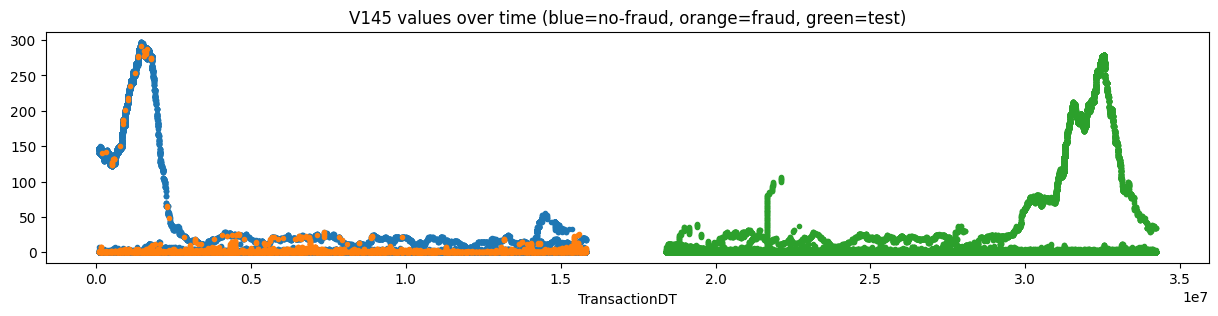

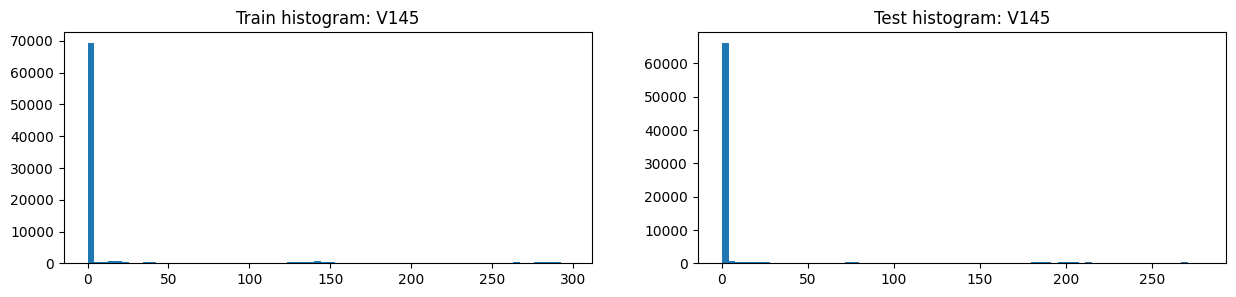

,V145,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,81951.000000,3651.000000,78300.000000,76055.000000,8913.000000,67142.000000
1,mean,22.112946,3.641194,22.974253,17.100598,1.719399,19.142429
2,std,64.371860,22.013184,65.556946,54.471618,6.628048,57.616335
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,75%,1.000000,1.500000,0.000000,0.000000,0.000000,0.000000
7,max,297.000000,292.000000,297.000000,279.000000,85.000000,279.000000
8,unique values,261.000000,62.000000,261.000000,281.000000,87.000000,281.000000
9,NaNs,508589.000000,17012.000000,491577.000000,430636.000000,92426.000000,338211.000000


,V145,Count in train (desc),Mean target,Sum target,Count in test
0,-999.0,508589,0.033449,17012,430636.0
1,0.0,61241,0.034405,2107,58604.0
2,1.0,4958,0.127269,631,5071.0
3,2.0,1847,0.177585,328,1672.0
4,3.0,832,0.213942,178,692.0
5,35.0,429,0.000000,0,23.0
6,4.0,367,0.228883,84,297.0
7,142.0,244,0.004098,1,14.0
8,143.0,241,0.000000,0,21.0
9,39.0,231,0.000000,0,3.0


,V145,Count in train,Mean target,Sum target (desc),Count in test
0,-999.0,508589,0.033449,17012,430636
1,0.0,61241,0.034405,2107,58604
2,1.0,4958,0.127269,631,5071
3,2.0,1847,0.177585,328,1672
4,3.0,832,0.213942,178,692
5,4.0,367,0.228883,84,297
6,5.0,212,0.259434,55,205
7,6.0,105,0.323810,34,106
8,7.0,79,0.341772,27,105
9,8.0,90,0.244444,22,104


KeyboardInterrupt: 

In [6]:
# EDA for other columns
for col in list(tr_tr.columns.values[COLS_TO_SHOW:]):
    proc(col) # Run EDA